# **P6 - Classifiez automatiquement des biens de consommation**

## **Sommaire**

1. [Import](#Import)  
2. [Jeu de données](#Jeu_de_données)    
3. [Méthodes NLP basiques](#Méthodes_NLP_basiques)  
    1. [Bag of Words](#Bag_of_Words)  
    2. [Tf-Idf](#Tf-Idf)  
4. [Méthodes NLP avancées](#Méthodes_NLP_avancées)
    1. [Word2Vec](#Word2Vec)  
    2. [Universal Sentence Encoder](#Universal_Sentence_Encoder)
    3. [BERT](#BERT)  
6. [Méthodes de traitement d'image basiques](#Méthodes_de_traitement_d'image_basiques)    
7. [Méthodes de traitement d'image avancées](#Méthodes_de_traitement_d'image_avancées)

## **Import**

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import gensim
import cv2
import os
import torch
import zipfile

import sklearn
import tensorflow as tf
import torchvision
import tensorflow_hub as hub
import matplotlib
import PIL
import torchvision.transforms as transforms

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from torchvision import models
from PIL import Image
from transformers import AutoTokenizer, AutoModel

# Affichage des versions
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"NLTK: {nltk.__version__}")
print(f"Gensim: {gensim.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"OpenCV: {cv2.__version__}")
print(f"PyTorch: {torch.__version__}")
print(f"TensorFlow: {tf.__version__}")
print(f"TensorFlow Hub: {hub.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"Pillow (PIL): {PIL.__version__}")

# Vérification des modules transformers
try:
    import transformers
    print(f"Transformers: {transformers.__version__}")
except ImportError:
    print("Transformers n'est pas installé.")

# Vérification de l'installation de NLTK Stopwords
try:
    stopwords.words("english")
    print("NLTK stopwords disponibles.")
except LookupError:
    print("Téléchargement des stopwords NLTK...")
    nltk.download("stopwords")

# Vérification de WordNet Lemmatizer
try:
    WordNetLemmatizer()
    print("NLTK WordNet Lemmatizer disponible.")
except LookupError:
    print("Téléchargement de WordNet pour NLTK...")
    nltk.download("wordnet")



Pandas: 2.2.2
Numpy: 1.26.4
NLTK: 3.8.1
Gensim: 4.3.3
Scikit-learn: 1.4.2
Matplotlib: 3.8.4
OpenCV: 4.11.0
PyTorch: 2.5.1+cpu
TensorFlow: 2.18.0
TensorFlow Hub: 0.16.1
torchvision: 0.20.1+cpu
Pillow (PIL): 10.3.0
Transformers: 4.48.1
NLTK stopwords disponibles.
NLTK WordNet Lemmatizer disponible.


## **Jeu de données**

Dans un premier on va réaliser certaines opérations :

In [4]:
# Télécharger les ressources nécessaires
nltk.download('stopwords')  
nltk.download('wordnet')    

# Charger les stopwords et initialiser le lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Fonction de prétraitement des textes
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text.lower())  
    tokens = text.split()  
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  
    return ' '.join(tokens)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\guill\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Nous pouvons à présent charger notre fichier

In [6]:
df = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")

# Vérifie les premières lignes pour voir les colonnes disponibles
print(df.head())

                            uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed Ki

In [7]:
df['cleaned_description'] = df['description'].apply(preprocess_text)

In [8]:
print(df[['description', 'cleaned_description']].head())

                                         description  \
0  Key Features of Elegance Polyester Multicolor ...   
1  Specifications of Sathiyas Cotton Bath Towel (...   
2  Key Features of Eurospa Cotton Terry Face Towe...   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4  Key Features of Jaipur Print Cotton Floral Kin...   

                                 cleaned_description  
0  key feature elegance polyester multicolor abst...  
1  specification sathiyas cotton bath towel 3 bat...  
2  key feature eurospa cotton terry face towel se...  
3  key feature santosh royal fashion cotton print...  
4  key feature jaipur print cotton floral king si...  


## **Méthodes NLP basiques**

### Bag of Words

Commençons notre étude de faisabilité avec Bag of Words

In [76]:
# Initialiser le vectoriseur Bag of Words
bow_vectorizer = CountVectorizer(max_features=500) 

# Appliquer Bag of Words sur la colonne 'cleaned_description'
bow_features = bow_vectorizer.fit_transform(df['cleaned_description'])

# Afficher la taille de la matrice Bag of Words
print(f"Taille de la matrice Bag of Words : {bow_features.shape}")

Taille de la matrice Bag of Words : (1050, 500)


In [77]:
print("Mots retenus dans le vocabulaire :")
print(bow_vectorizer.get_feature_names_out())

Mots retenus dans le vocabulaire :
['10' '100' '12' '13' '15' '156' '16' '17' '18' '195v39a' '199' '20' '299'
 '30' '300' '35' '350' '399' '40' '45' '50' '55' '60' '65' '75' 'abstract'
 'accessory' 'actual' 'adapter' 'add' 'additional' 'adorable' 'affordable'
 'akup' 'also' 'aluminium' 'analog' 'android' 'antique' 'apple' 'apply'
 'area' 'aroma' 'around' 'art' 'attractive' 'available' 'baby' 'back'
 'bag' 'bath' 'battery' 'beautiful' 'beautifully' 'beauty' 'bed' 'bedroom'
 'bedsheet' 'best' 'black' 'blanket' 'bleach' 'blue' 'body' 'bottle'
 'bowl' 'box' 'boy' 'brand' 'brass' 'break' 'bring' 'brings' 'broadcast'
 'brown' 'brush' 'buckle' 'buddha' 'bulb' 'button' 'buy' 'cable' 'canvas'
 'capacity' 'care' 'carpet' 'carry' 'case' 'cash' 'casual' 'catchy' 'cell'
 'ceramic' 'certification' 'charger' 'check' 'cheer' 'clasp' 'clean'
 'clear' 'cloth' 'cm' 'code' 'coffee' 'coffeetea' 'collection' 'color'
 'colour' 'combo' 'come' 'comfort' 'comfortable' 'comforter' 'compatible'
 'conditioner' 'co

In [78]:
bow_df = pd.DataFrame(bow_features.toarray(), columns=bow_vectorizer.get_feature_names_out())
print(bow_df.head())  

   10  100  12  13  15  156  16  17  18  195v39a  ...  wood  wooden  work  \
0   0    1   0   0   0    0   0   0   0        0  ...     0       0     0   
1   0    0   0   0   0    0   0   0   0        0  ...     0       0     0   
2   1    2   0   0   0    0   0   0   0        0  ...     0       0     0   
3   0    0   0   0   0    0   1   0   0        0  ...     0       0     0   
4   0    2   0   0   0    0   0   1   0        0  ...     0       0     0   

   would  wrap  year  yellow  yes  yet  youre  
0      0     0     0       0    0    0      0  
1      0     0     0       2    1    0      0  
2      0     0     1       0    0    0      0  
3      0     0     0       0    1    0      0  
4      0     0     0       0    1    0      0  

[5 rows x 500 columns]


In [79]:
# Réduire les dimensions à 2 composantes principales
pca = PCA(n_components=2)
pca_result = pca.fit_transform(bow_features.toarray())

# Vérifier les dimensions après réduction
print(f"Dimensions après PCA : {pca_result.shape}")

Dimensions après PCA : (1050, 2)


Créons la feature catégorie qui nous servira tout au long du projet.

In [20]:
# Extraire la catégorie principale
df['category'] = df['product_category_tree'].str.extract(r'\["([^>]+)')

# Vérifier les premières catégories extraites
print(df['category'].head())

0    Home Furnishing 
1          Baby Care 
2          Baby Care 
3    Home Furnishing 
4    Home Furnishing 
Name: category, dtype: object


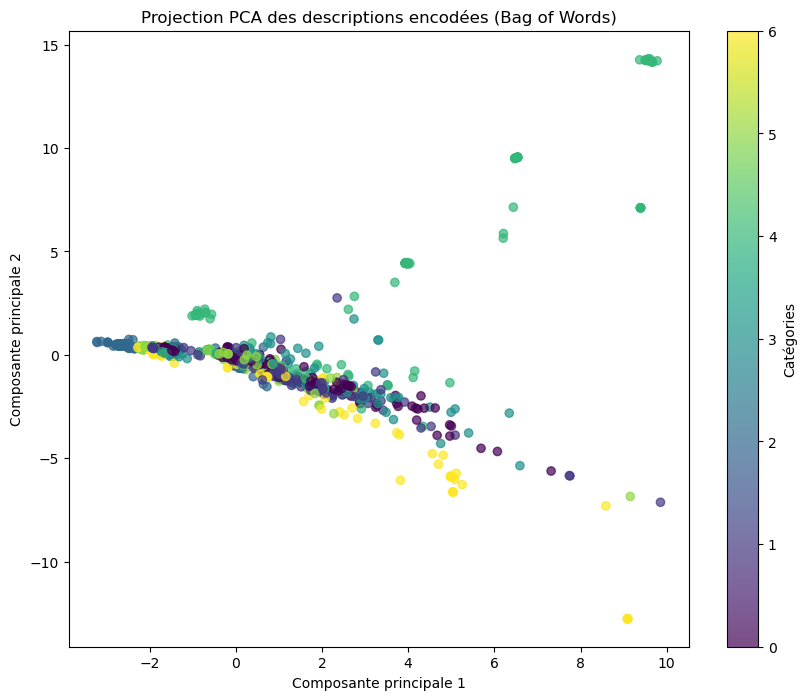

In [82]:
# Visualisation avec Matplotlib
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['category'].factorize()[0], cmap='viridis', alpha=0.7)
plt.colorbar(label='Catégories')
plt.title("Projection PCA des descriptions encodées (Bag of Words)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()

In [83]:
# Clustering avec KMeans sur les résultats PCA
kmeans = KMeans(n_clusters=len(df['category'].unique()), random_state=42)
kmeans_clusters = kmeans.fit_predict(pca_result)

# Calcul des scores
ari = adjusted_rand_score(df['category'], kmeans_clusters)

print(f"Adjusted Rand Index (ARI) : {ari}")

Adjusted Rand Index (ARI) : 0.045845110573001


On obtient un résultat peu interéssant. Essayons une autre méthode.

### Tf-ldf

Passons maintenant à Tf-Idf :

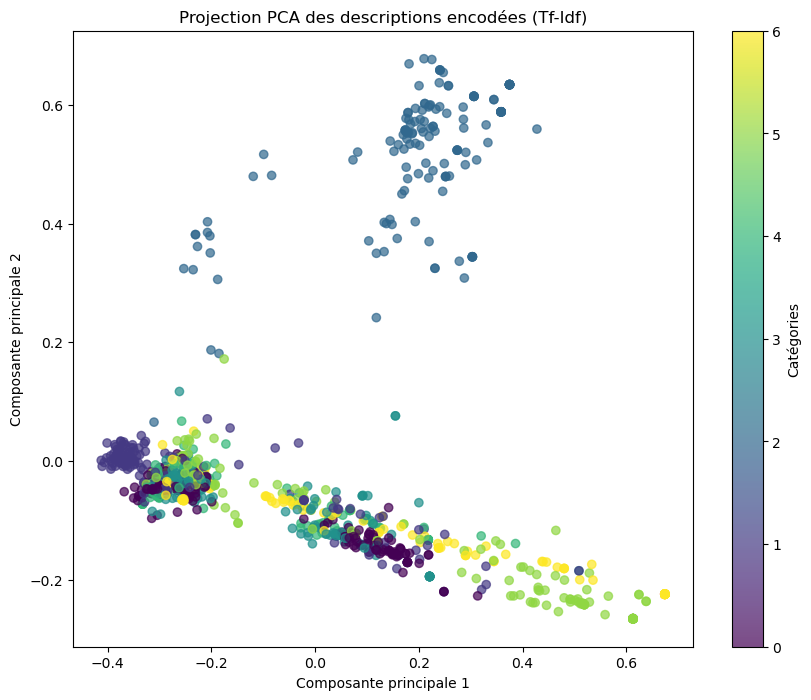

In [87]:
# Initialiser le vectoriseur Tf-Idf
tfidf_vectorizer = TfidfVectorizer(max_features=500)  # Limiter à 500 mots les plus importants

# Appliquer Tf-Idf sur la colonne 'cleaned_description'
tfidf_features = tfidf_vectorizer.fit_transform(df['cleaned_description'])

# Réduire avec PCA
pca_tfidf = PCA(n_components=2)
pca_result_tfidf = pca_tfidf.fit_transform(tfidf_features.toarray())

# Visualiser les données projetées avec Tf-Idf
plt.figure(figsize=(10, 8))
plt.scatter(
    pca_result_tfidf[:, 0], 
    pca_result_tfidf[:, 1], 
    c=df['category'].factorize()[0], 
    cmap='viridis', 
    alpha=0.7
)
plt.colorbar(label='Catégories')
plt.title("Projection PCA des descriptions encodées (Tf-Idf)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()

In [88]:
# Clustering avec KMeans sur les résultats PCA
kmeans = KMeans(n_clusters=len(df['category'].unique()), random_state=42)
kmeans_clusters = kmeans.fit_predict(pca_result_tfidf)

# Calcul des scores
ari = adjusted_rand_score(df['category'], kmeans_clusters)

print(f"Adjusted Rand Index (ARI) : {ari}")

Adjusted Rand Index (ARI) : 0.1385658047144364


On obtient un résultat un peu plus interessant mais on aiemrait mieux.

Résumé étape 1 :
 - Prétraitement des descriptions textuelles : Nettoyage, lemmatisation, suppression des stopwords.
 - Encodage basique : Bag of Words (BoW) et Tf-Idf.
 - Réduction de dimension : PCA pour visualiser les clusters.
 - Évaluation quantitative : ARI pour mesurer la qualité des regroupements.

## **Méthodes NLP avancées**

Les méthodes NLP basiques n'apportant pas le rendement espéré, passons à des méthode plus avancées

### Word2Vec

In [94]:
# Préparer les données : chaque description devient une liste de mots
sentences = [desc.split() for desc in df['cleaned_description']]

# Afficher un exemple
print(sentences[:2])  

[['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtainelegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '213', 'cm', 'height', 'pack', '2', 'price', 'r', '899', 'curtain', 'enhances', 'look', 'interiorsthis', 'curtain', 'made', '100', 'high', 'quality', 'polyester', 'fabricit', 'feature', 'eyelet', 'style', 'stitch', 'metal', 'ringit', 'make', 'room', 'environment', 'romantic', 'lovingthis', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparancegive', 'home', 'bright', 'modernistic', 'appeal', 'design', 'surreal', 'attention', 'sure', 'steal', 'heart', 'contemporary', 'eyelet', 'valance', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moment', 'joyous', 'beauty', 'given', 'soothing', 'print', 'bring', 'home', 'e

In [95]:
# Entraîner le modèle Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Vérifier les mots appris par le modèle
print("Quelques mots du vocabulaire Word2Vec :", list(word2vec_model.wv.index_to_key)[:10])  # Afficher les 10 premiers mots

Quelques mots du vocabulaire Word2Vec : ['product', 'free', 'r', 'buy', 'delivery', 'cash', 'genuine', 'shipping', 'price', 'replacement']


In [96]:
# Calculer le vecteur moyen pour chaque description
def get_mean_vector(sentence, model):
    # Filtrer les mots présents dans le vocabulaire du modèle
    vectors = [model.wv[word] for word in sentence if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Si aucun mot n'est dans le vocabulaire, retourner un vecteur nul

# Appliquer la fonction à chaque description
description_vectors = [get_mean_vector(sentence, word2vec_model) for sentence in sentences]

# Afficher la taille du vecteur pour la première description
print("Taille d'un vecteur :", len(description_vectors[0]))

Taille d'un vecteur : 100


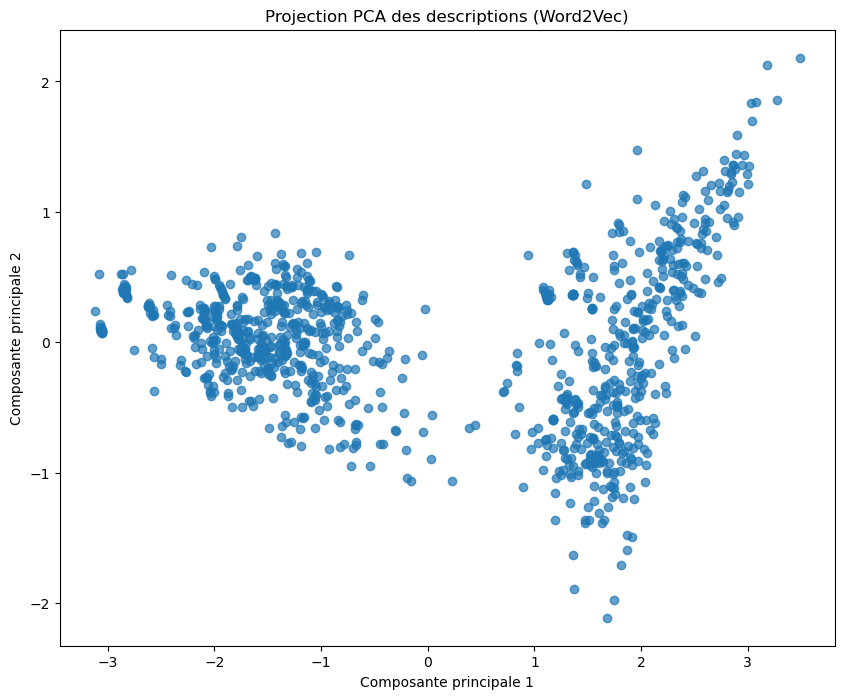

In [97]:
# Réduction de dimension à 2 dimensions
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(description_vectors)

# Visualisation des données
plt.figure(figsize=(10, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], alpha=0.7)
plt.title("Projection PCA des descriptions (Word2Vec)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()

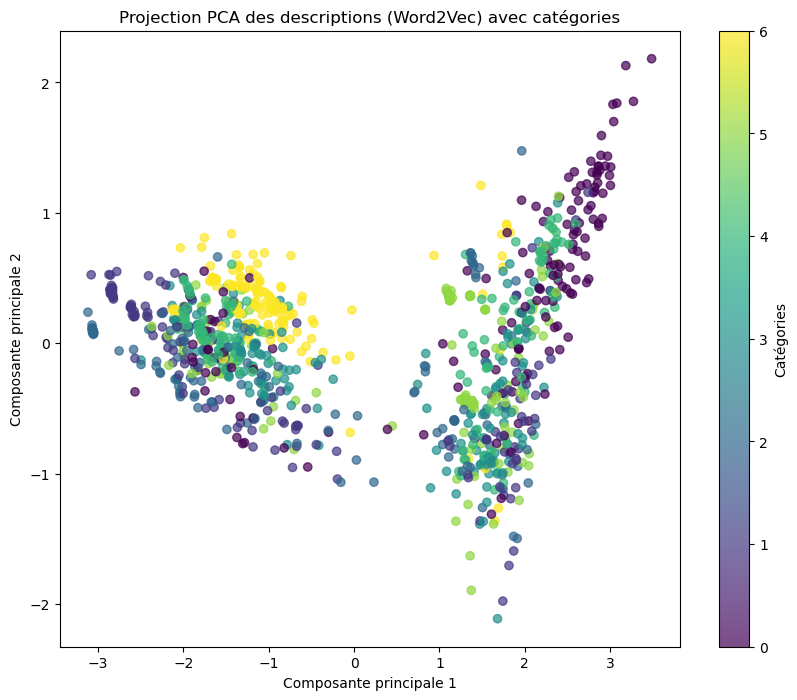

In [99]:
# Vérifier que la colonne 'category' existe
if 'category' in df.columns:
    categories = df['category']  # Extraire les catégories
else:
    raise ValueError("La colonne 'category' n'existe pas dans le DataFrame.")
    
# Convertir les catégories en nombres
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
category_labels = label_encoder.fit_transform(categories)

# Visualiser le graphique avec les catégories
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_vectors[:, 0], reduced_vectors[:, 1],
    c=category_labels, cmap='viridis', alpha=0.7
)
plt.colorbar(scatter, label="Catégories")
plt.title("Projection PCA des descriptions (Word2Vec) avec catégories")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()

In [101]:
# Appliquer KMeans pour générer des clusters
num_categories = len(df['category'].unique())
kmeans = KMeans(n_clusters=num_categories, random_state=42)
predicted_clusters = kmeans.fit_predict(description_vectors)

# Calculer l'ARI et le NMI
ari = adjusted_rand_score(df['category'], predicted_clusters)

print(f"Adjusted Rand Index (ARI) : {ari}")

Adjusted Rand Index (ARI) : 0.18733392351905523


Résultat en légère hausse mais toujours insufisant.

### Universal Sentence Encoder

In [105]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")
print("Modèle USE chargé.")

Modèle USE chargé.


In [107]:
# Appliquer le modèle USE à toutes les descriptions à la fois
use_embeddings = embed(df['cleaned_description'].tolist()).numpy()

# Vérifier la taille du vecteur pour la première description
print("Taille d'un vecteur USE :", len(use_embeddings[0]))

Taille d'un vecteur USE : 512


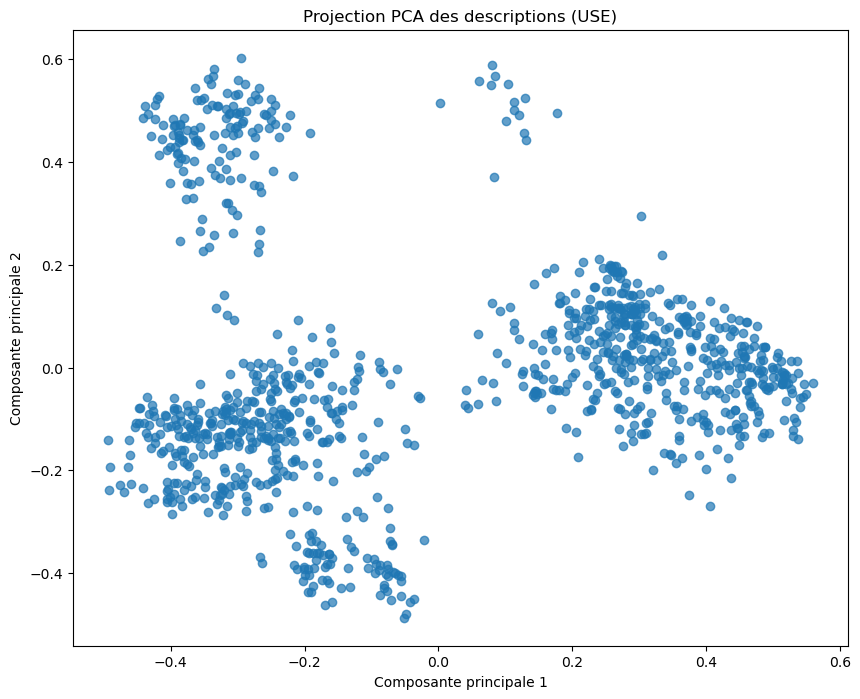

In [109]:
# Réduction de dimension à 2D avec PCA
reduced_use_embeddings = PCA(n_components=2).fit_transform(use_embeddings)

# Visualisation des données
plt.figure(figsize=(10, 8))
plt.scatter(reduced_use_embeddings[:, 0], reduced_use_embeddings[:, 1], alpha=0.7)
plt.title("Projection PCA des descriptions (USE)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()

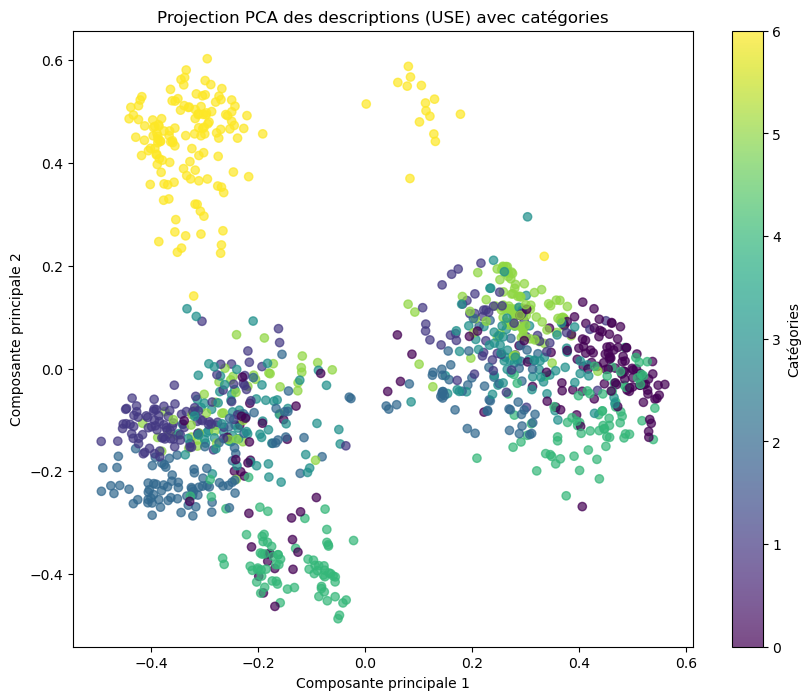

In [111]:
# Convertir les catégories en nombres
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
category_labels = label_encoder.fit_transform(categories)

# Visualiser le graphique avec les catégories
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    reduced_use_embeddings[:, 0], reduced_use_embeddings[:, 1],
    c=category_labels, cmap='viridis', alpha=0.7
)
plt.colorbar(scatter, label="Catégories")
plt.title("Projection PCA des descriptions (USE) avec catégories")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()

In [113]:
# Appliquer KMeans pour générer des clusters 
num_categories = len(df['category'].unique())
kmeans_use = KMeans(n_clusters=num_categories, random_state=42)
predicted_clusters_use = kmeans_use.fit_predict(use_embeddings)

# Calculer l'ARI et le NMI
ari_use = adjusted_rand_score(df['category'], predicted_clusters_use)

print(f"Adjusted Rand Index (ARI) avec USE : {ari_use}")

Adjusted Rand Index (ARI) avec USE : 0.3325302094632958


Résultat bien plus intéressant. Nous sommes sur la bonne voie.

### BERT

In [14]:
# Charger le tokenizer et le modèle BERT en anglais
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

print("BERT model and tokenizer loaded successfully for English!")

BERT model and tokenizer loaded successfully for English!


In [15]:
# Fonction pour obtenir l'embedding BERT à partir d'un texte
def get_bert_embedding(text, tokenizer, model, max_length=128):
    
    inputs = tokenizer(
        text, 
        return_tensors='pt', 
        truncation=True, 
        padding='max_length', 
        max_length=max_length
    )
    with torch.no_grad():
        outputs = model(**inputs)
    # Extraction de l'embedding du token [CLS]
    cls_embedding = outputs.last_hidden_state[:, 0, :]  
    return cls_embedding.squeeze().numpy()

In [16]:
embeddings = []
for text in df['cleaned_description']:
    emb = get_bert_embedding(text, tokenizer, model)
    embeddings.append(emb)
embeddings = np.array(embeddings)  

print("Dimension des embeddings BERT:", embeddings.shape)

Dimension des embeddings BERT: (1050, 768)


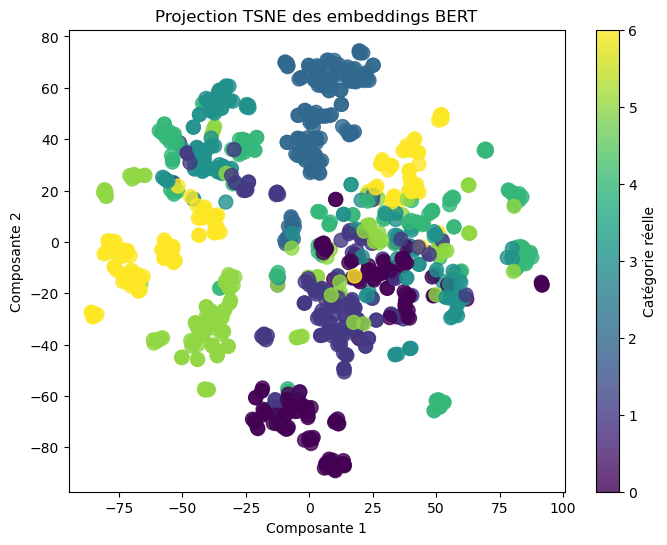

In [22]:
# Réduction de dimension avec TSNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5) 
embeddings_2d = tsne.fit_transform(embeddings)

# Visualisation de la projection en 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
                      c=df['category'].factorize()[0], cmap='viridis', alpha=0.8, s=100)
plt.colorbar(scatter, label='Catégorie réelle')
plt.title("Projection TSNE des embeddings BERT")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.show()

In [23]:
# Clustering et évaluation
n_clusters = df['category'].nunique()  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(embeddings_2d)

# Ajout des clusters obtenus dans le DataFrame
df['cluster'] = clusters

# Évaluation de la similarité entre clusters et catégories réelles avec l'Adjusted Rand Index (ARI)
ari = adjusted_rand_score(df['category'], df['cluster'])

print("Adjusted Rand Index (ARI) :", ari)

Adjusted Rand Index (ARI) : 0.29750021830551404


Résultat intéressant mais moins important que Universal Sentence Encoder

Résumé Etape 2 :
Utilisation de 3 méthodes avancé (Word2Vec, BERT, Universal Sentence Encoder). Des ari en hausse démontrant l'intérêt de ces méthodes. Parmi les 5 méthodes utilisé, Universal Sentence Encoder semble etre la plus performantes.

## **Méthodes de traitement d'image basiques**

Nous passons maintenant aux traitement d'image. Nous allons dans un premier temps évaluer la faisabilité de classification en utilisant des techniques de traitement d'images basiques (SIFT).

In [26]:
# Chemin vers le fichier ZIP
zip_path = "C:/Users/guill/OpenClassroom/Projet 6/Images - Copie.zip"
extract_to = "./Images" 

# Extraction
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Fichiers extraits dans : {extract_to}")

Fichiers extraits dans : ./Images


In [27]:
# Lister les fichiers extraits
extracted_files = os.listdir("./Images")
print(f"Nombre de fichiers extraits : {len(extracted_files)}")
print(f"Quelques fichiers : {extracted_files[:5]}")

Nombre de fichiers extraits : 1
Quelques fichiers : ['Images - Copie']


In [28]:
# Chemin vers le sous-dossier
subfolder_path = "./Images/Images - Copie"

# Lister les fichiers dans le sous-dossier
if os.path.exists(subfolder_path):
    files_in_subfolder = os.listdir(subfolder_path)
    print(f"Nombre de fichiers dans le sous-dossier : {len(files_in_subfolder)}")
    print(f"Quelques fichiers : {files_in_subfolder[:5]}")
else:
    print("Le sous-dossier n'existe pas. Vérifie le chemin.")

Nombre de fichiers dans le sous-dossier : 1053
Quelques fichiers : ['009099b1f6e1e8f893ec29a7023153c4.jpg', '0096e89cc25a8b96fb9808716406fe94.jpg', '00cbbc837d340fa163d11e169fbdb952.jpg', '00d84a518e0550612fcfcba3b02b6255.jpg', '00e966a5049a262cfc72e6bbf68b80e7.jpg']


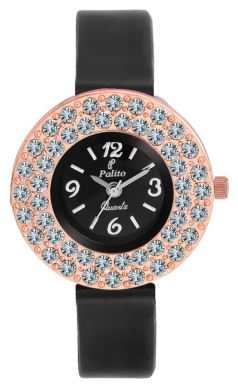

In [29]:
# Chemin vers une image exemple
image_path = "./Images/Images - Copie/" + files_in_subfolder[0]  # On prend la première image
image = cv2.imread(image_path)

# Convertir BGR vers RGB 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Affichage de l'image
plt.imshow(image)
plt.axis("off")
plt.show()

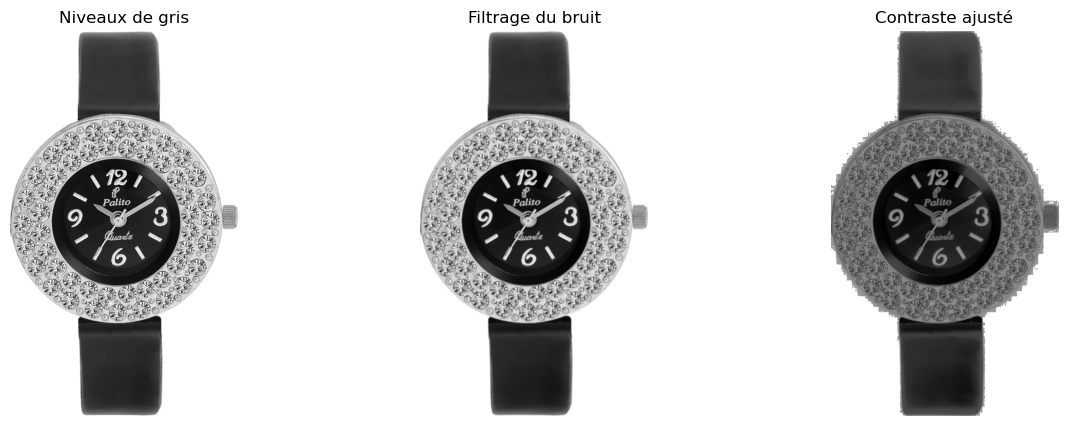

In [30]:
# Convertir en niveaux de gris
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Filtrage du bruit
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Augmentation du contraste
equalized = cv2.equalizeHist(blurred)

# Affichage
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(gray, cmap="gray")
axes[0].set_title("Niveaux de gris")
axes[1].imshow(blurred, cmap="gray")
axes[1].set_title("Filtrage du bruit")
axes[2].imshow(equalized, cmap="gray")
axes[2].set_title("Contraste ajusté")
for ax in axes:
    ax.axis("off")
plt.show()

Nombre de keypoints détectés : 5192


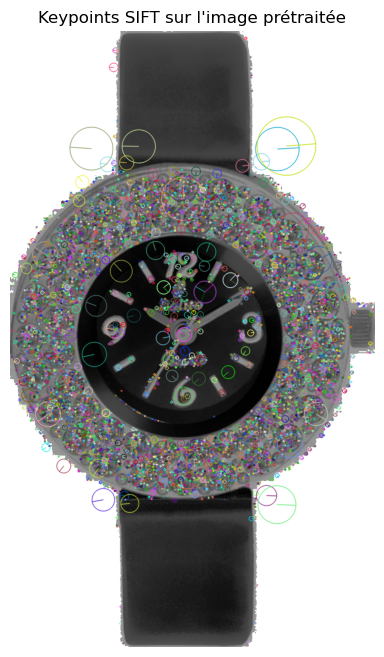

In [31]:
# Utilisation de SIFT
sift = cv2.SIFT_create()

# Détecter les keypoints et calculer les descripteurs sur l'image prétraitée
keypoints, descriptors = sift.detectAndCompute(equalized, None)

print("Nombre de keypoints détectés :", len(keypoints))

# Dessiner les keypoints sur l'image 
img_keypoints = cv2.drawKeypoints(equalized, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Afficher l'image avec les keypoints SIFT
plt.figure(figsize=(10, 8))
plt.imshow(img_keypoints, cmap="gray")
plt.title("Keypoints SIFT sur l'image prétraitée")
plt.axis("off")
plt.show()

Shape des descripteurs après PCA : (5192, 2)


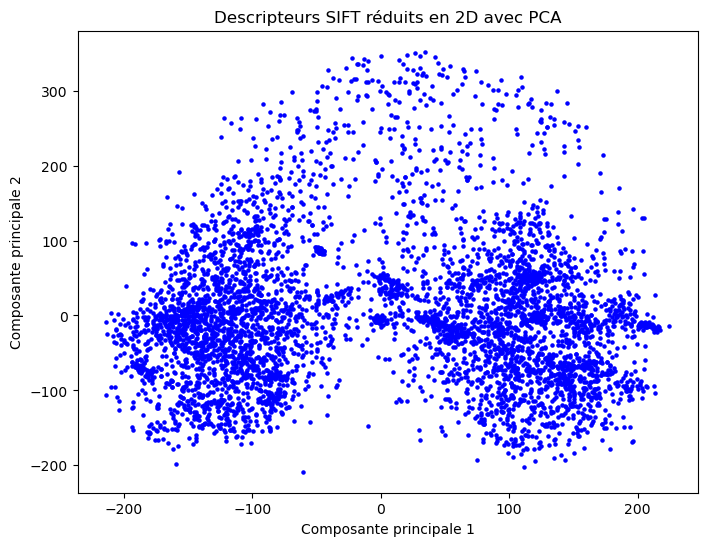

In [32]:
# Réduction des descripteurs SIFT à 2 dimensions pour visualisation
pca = PCA(n_components=2)
descriptors_reduced = pca.fit_transform(descriptors)

print("Shape des descripteurs après PCA :", descriptors_reduced.shape)

# Visualisation des descripteurs réduits
plt.figure(figsize=(8, 6))
plt.scatter(descriptors_reduced[:, 0], descriptors_reduced[:, 1], c='blue', s=5)
plt.title("Descripteurs SIFT réduits en 2D avec PCA")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()

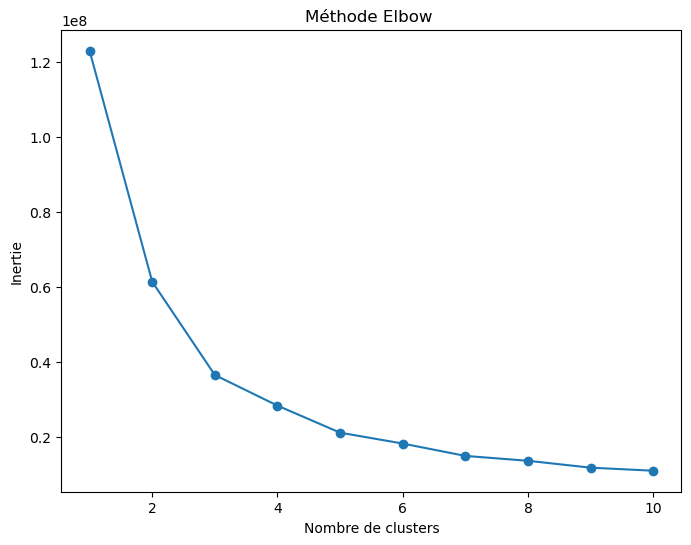

In [33]:
# Méthode Elbow pour déterminer le nombre optimal de clusters
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(descriptors_reduced)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_range, inertias, marker='o')
plt.xlabel("Nombre de clusters")
plt.ylabel("Inertie")
plt.title("Méthode Elbow ")
plt.show()

ARI (Adjusted Rand Index) : -0.0002930729036225392


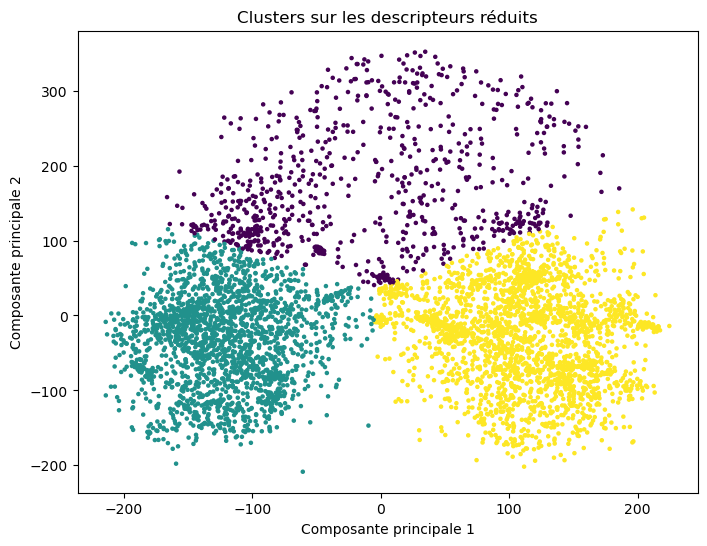

In [34]:
# Clustering sur les descripteurs réduits
n_clusters = 3 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_labels = kmeans.fit_predict(descriptors_reduced)

# Calcul de l'ARI
random_labels = np.random.randint(0, n_clusters, descriptors_reduced.shape[0])
ari = adjusted_rand_score(random_labels, predicted_labels)
print("ARI (Adjusted Rand Index) :", ari)

# Visualisation des clusters obtenus
plt.figure(figsize=(8, 6))
plt.scatter(descriptors_reduced[:, 0], descriptors_reduced[:, 1],
            c=predicted_labels, cmap='viridis', s=5)
plt.title("Clusters sur les descripteurs réduits")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.show()

Au vu du résultat obtenus, SIFT ne permet pas de repondre à  notre problématiques. Essayons une méthodes plus avancées avec CNN.

## **Méthode de traitement d'image avancées**

In [44]:
# Vérification de l'utilisation du GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Chargement du modèle pré-entraîné 
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-1])) 
model.to(device)
model.eval()  

Using device: cpu


C:\Users\guill\OneDrive\Documents\OpenClassroom\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\guill\OneDrive\Documents\OpenClassroom\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [45]:
# Transformations pour adapter les images à ResNet50
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionnement
    transforms.ToTensor(),  # Conversion en tenseur PyTorch
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisation ImageNet
])

# Fonction d'extraction des features CNN
def extract_features_cnn(image_path):
    image_path = os.path.join("./Images/Images - Copie", image_path)  # Ajuster le chemin si besoin
    
    try:
        image = Image.open(image_path).convert("RGB")  # Charger l'image
        image = transform(image).unsqueeze(0).to(device)  # Appliquer les transformations et ajouter une dimension batch
    except Exception as e:
        print(f"Erreur lors du chargement de l'image {image_path}: {e}")
        return np.zeros(2048)  # Retourne un vecteur nul si l'image est invalide
    
    with torch.no_grad():
        features = model(image).squeeze().cpu().numpy()  # Extraction des features

    return features

In [46]:
# Appliquer l'extraction des features pour toutes les images
cnn_features = []
for filename in df['image']:
    descriptor = extract_features_cnn(filename)
    cnn_features.append(descriptor)

cnn_features = np.array(cnn_features)  
print("Shape des features CNN:", cnn_features.shape)

C:\Users\guill\OneDrive\Documents\OpenClassroom\Lib\site-packages\PIL\Image.py:3218: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Shape des features CNN: (1050, 2048)


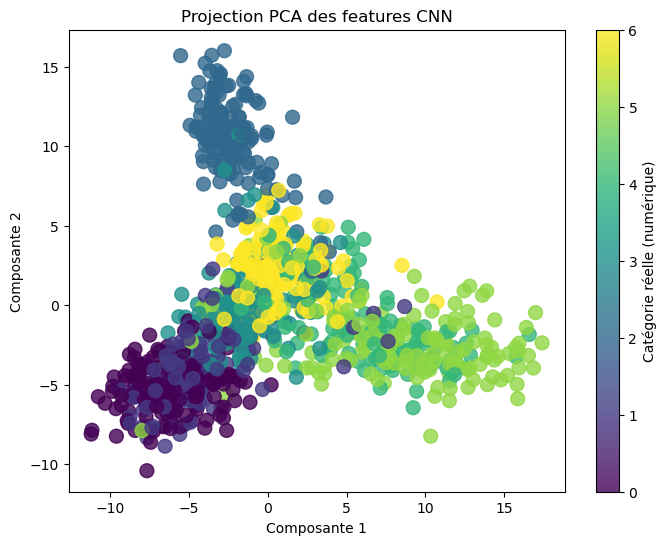

In [49]:
# Réduction de dimension avec PCA
pca = PCA(n_components=2, random_state=42)
cnn_features_2d = pca.fit_transform(cnn_features)

# Conversion des catégories en valeurs numériques
df['category_numeric'] = df['category'].factorize()[0]

# Visualisation en 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(cnn_features_2d[:, 0], cnn_features_2d[:, 1], 
                      c=df['category_numeric'], cmap='viridis', alpha=0.8, s=100)
plt.colorbar(scatter, label='Catégorie réelle (numérique)')
plt.title("Projection PCA des features CNN")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.show()

In [50]:
# Application de K-Means sur les features réduites
n_clusters = df['category'].nunique()
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(cnn_features_2d)

# Ajout des clusters obtenus dans le DataFrame
df['cluster_cnn'] = clusters

# Évaluation avec l'ARI
ari_cnn = adjusted_rand_score(df['category_numeric'], df['cluster_cnn'])
print("Adjusted Rand Index (ARI) des features CNN :", ari_cnn)

Adjusted Rand Index (ARI) des features CNN : 0.40654312102574625


Points positifs :

    L’ARI n'est pas proche de 0, ce qui signifie qu'il y a une certaine structure identifiable dans les features CNN.
    → Cela montre que le modèle CNN extrait des caractéristiques qui ont du sens pour la classification.

    L’ARI est bien supérieur à un clustering totalement aléatoire.
    → Cela suggère que certaines catégories sont mieux séparées que d’autres.

Points négatifs :

    Un ARI de 0.41 est encore loin d’une classification fiable.
    → Cela indique que le modèle CNN seul n'est pas suffisant pour une bonne segmentation des images.
    → Il est probable que certaines catégories se chevauchent trop dans l’espace des features.

La classification par CNN semble possible, car l'ARI montre qu'il y a une structure détectable. Mais ce n'est pas encore assez robuste pour une classification fiable.